In [1161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
from scipy.stats import f_oneway

from optbinning import Scorecard, BinningProcess, OptimalBinning
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks,ScorecardMonitoring

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score

pd.set_option('display.max_rows', 100)



In [ ]:
df = pd.read_excel("DatosPractica_Scoring.xlsx")
#df.drop(columns="ID", inplace=True)

Nuevos = df.iloc[1285:]
df = df[:1285]

y = df[["Cardhldr", "default"]]
todas_las_columnas = list(df.columns)

for i in ["Cardhldr", "ID"]:
    todas_las_columnas.remove(i)


df = df[todas_las_columnas]
df['extr_age'] = np.where((df['Age'] < 18), 1, 0)
media_age = df["Age"].mean()
df.loc[df['Age'] < 18, 'Age'] = media_age

df["extr_avg"] = np.where((df["Avgexp"]<2), 1, 0)



print(df.to_string())

      default        Age   Income   Exp_Inc       Avgexp  Ownrent  Selfempl  Depndt    Inc_per  Cur_add  Major  Active  extr
0         0.0  27.083330   2.4000  0.016798    33.013330        0         0       0   2.400000       56      1       1     0
1         1.0  24.250000   3.5000  0.069963   203.891700        0         0       0   3.500000       60      1      11     0
2         NaN  27.416670   1.6000  0.000750     0.000000        1         0       1   0.800000       30      0       0     0
3         0.0  40.333330   3.0670  0.159700   408.082500        0         0       2   1.022333       18      0       0     0
4         0.0  28.166670   3.3500  0.071625   199.369200        1         0       0   3.350000       18      1       2     0
5         NaN  34.250000   1.9440  0.000617     0.000000        0         0       1   0.972000       54      1       1     0
6         1.0  23.250000   1.8769  0.353630   553.106700        0         0       0   1.876900       12      1       3     0


In [1163]:
#df = pd.concat([df,pd.DataFrame([[0,0,0,0,0,np.nan,0,0,0,0,0]], columns=df.columns)])

In [1164]:
df.dtypes

default     float64
Age         float64
Income      float64
Exp_Inc     float64
Avgexp      float64
Ownrent       int64
Selfempl      int64
Depndt        int64
Inc_per     float64
Cur_add       int64
Major         int64
Active        int64
dtype: object

In [1165]:
aceptados = df[y["Cardhldr"]>0.7]
Rechazados = df[y["Cardhldr"]<=0.7]
y_aceptados = y[y["Cardhldr"]>0.7]["default"]
y_aceptados

0       0.0
1       1.0
3       0.0
4       0.0
6       1.0
       ... 
1278    0.0
1280    0.0
1282    0.0
1283    0.0
1284    1.0
Name: default, Length: 994, dtype: float64

In [1166]:
def buscar_nan(df):
    return df[df.isna().any(axis=1)]

todas_las_columnas.remove("default")
df_uso = df[todas_las_columnas]
df_nan = buscar_nan(df_uso)
df_nan


,Age,Income,Exp_Inc,Avgexp,Ownrent,Selfempl,Depndt,Inc_per,Cur_add,Major,Active


In [1167]:
def atipicos_rango_intercuartilico(df, variable):
    Q1 = df[variable].quantile(0.25)
    Q3 = df[variable].quantile(0.75)

    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR

    df = df[(df[variable]<lower_bound) | (df[variable]>upper_bound)]
    return df



def df_join(funcion, df):
    todas_las_columnas = list(df.columns)
    df_atipicos_inter = pd.DataFrame()
    for variable in todas_las_columnas:
        df_atipicios = funcion(df, variable)
        print(df_atipicios.to_string())
        df_atipicos_inter = pd.concat([df_atipicos_inter, df_atipicios])
        print(variable)

    return df_atipicos_inter



df_join(atipicos_rango_intercuartilico, df_uso)


            Age  Income   Exp_Inc      Avgexp  Ownrent  Selfempl  Depndt   Inc_per  Cur_add  Major  Active
20    63.750000  6.0000  0.001833    8.333333        0         0       0  6.000000       50      1      14
36    62.500000  2.6545  0.103745  229.493300        0         0       0  2.654500      100      1       1
82    63.416670  2.1375  0.000561    0.000000        1         0       0  2.137500      240      1       7
83    66.500000  3.2500  0.000369    0.000000        1         0       3  0.812500      300      1      13
105   80.166660  1.5000  0.000800    0.000000        0         0       0  1.500000       24      1       0
163   63.500000  6.4532  0.000186    0.000000        1         0       0  6.453200       42      1      13
267   65.916660  2.9500  0.048561  118.713300        1         0       1  1.475000      230      1      19
320   61.583330  3.7500  0.000320    0.000000        1         0       0  3.750000      288      1       5
333    0.750000  3.0000  0.000400    

Empty DataFrame
Columns: [Age, Income, Exp_Inc, Avgexp, Ownrent, Selfempl, Depndt, Inc_per, Cur_add, Major, Active]
Index: []
Ownrent
           Age   Income   Exp_Inc       Avgexp  Ownrent  Selfempl  Depndt    Inc_per  Cur_add  Major  Active
14    26.08333   2.3750  0.142851   282.725800        0         1       1   1.187500      114      1       1
18    21.66667   3.8400  0.000313     0.000000        0         1       1   1.920000       12      0       1
19    56.75000   7.5720  0.006669    41.333330        1         1       2   2.524000       39      1      18
31    34.58333   7.0000  0.035465   206.381700        0         1       6   1.000000       63      1       3
35    32.83333   3.7000  0.008999    26.996670        0         1       0   3.700000       60      1       7
78    53.00000  11.0000  0.000109     0.000000        1         1       0  11.000000      429      1       0
85    37.83333   5.1600  0.000233     0.000000        1         1       0   5.160000       86      1   

,Age,Income,Exp_Inc,Avgexp,Ownrent,Selfempl,Depndt,Inc_per,Cur_add,Major,Active
20,63.75000,6.0000,0.001833,8.333333,0,0,0,6.0000,50,1,14
36,62.50000,2.6545,0.103745,229.493300,0,0,0,2.6545,100,1,1
82,63.41667,2.1375,0.000561,0.000000,1,0,0,2.1375,240,1,7
83,66.50000,3.2500,0.000369,0.000000,1,0,3,0.8125,300,1,13
105,80.16666,1.5000,0.000800,0.000000,0,0,0,1.5000,24,1,0
...,...,...,...,...,...,...,...,...,...,...,...
857,26.00000,7.0000,0.221529,1292.003000,0,1,0,7.0000,13,1,31
1020,25.33333,2.6400,0.000455,0.000000,0,0,0,2.6400,24,1,33
1051,35.00000,9.9999,0.110106,917.540000,1,0,0,9.9999,72,1,29
1087,43.25000,6.7200,0.031428,175.997500,1,0,3,1.6800,30,1,27


In [1168]:
def valores_erroneos(df):
    """
    Cuenta los valores erroneos de cada variable en un dataframe
    sin tener en cuenta los valores erroneos.
    Los valores erroneos son:
        NaN o valor nulo
        Caracteres en columna numerica
        "?"
    
    Inputs:
        df: El DataFrame que contiene los datos.

    Returns:
        Df con los valores erroneos de cada columna de cada columna
    """
    nan_values = pd.DataFrame()
    quest_mark = pd.DataFrame()
    menores = pd.Series()

    for col in df.columns:
        nan_values[col] = df[col].isna()
        quest_mark[col] = df[col].apply(lambda col: (col == "?"))

    menores = (df['Age'] < 18).astype(int)
    nan_values = nan_values.sum(axis=1)
    quest_mark = quest_mark.sum(axis=1)

    return pd.DataFrame({"NaN": nan_values, "?": quest_mark, "Menores": menores})

erroneos = valores_erroneos(df_uso)

erroneos

,NaN,?,Menores
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
1280,0,0,0
1281,0,0,0
1282,0,0,0
1283,0,0,0


In [1169]:
def valores_atipicos(df, mode="intercuart"):
    # Primero seleccionaremos los datos que sean nuemricos
    numericas = df.select_dtypes(include=['int', 'int32', 'int64','float', 'float32', 'float64'])

    if mode == "intercuart":
        atipicos = pd.DataFrame()
        for col in numericas:
            qnt = df[col].quantile([0.25, 0.75]).dropna()
            Q1 = qnt.iloc[0]
            Q3 = qnt.iloc[1]
            H = 3 * (Q3 - Q1)

            limite_inferior = Q1 - H
            limite_superior = Q3 + H
            
            # Los valores atipicos seran:
            atipicos[col] = (df[col]<limite_inferior) | (df[col]>limite_superior)

        return atipicos.sum(axis=1)

    if mode == "std des":
        atipicos = pd.DataFrame()
        for col in numericas:
            media = df[col].mean()
            desv = df[col].std()

            limite_inferior = media - 3*desv
            limite_superior = media + 3*desv

            # Los valores atipicos seran:
            atipicos[col] = (df[col]<limite_inferior) | (df[col]>limite_superior)

        return atipicos.sum(axis=1)

atipicos = pd.DataFrame({"Rango Intercuartilico": valores_atipicos(df_uso, "intercuart"),
                         "Desviacion estandar": valores_atipicos(df_uso, "std des")})

In [1170]:
df_valores_erroneos = pd.concat([atipicos, erroneos], axis=1)
df_valores_erroneos["Total"] = df_valores_erroneos.sum(axis=1)
print(f"Nos quedariamos en total con {(df_valores_erroneos['Total'] == 0).sum()}")
print(df_valores_erroneos)
df_valores_erroneos[df_valores_erroneos["Total"]>0]

Nos quedariamos en total con 875
      Rango Intercuartilico  Desviacion estandar  NaN  ?  Menores  Total
0                         0                    0    0  0        0      0
1                         0                    0    0  0        0      0
2                         1                    0    0  0        0      1
3                         1                    0    0  0        0      1
4                         0                    0    0  0        0      0
...                     ...                  ...  ... ..      ...    ...
1280                      0                    0    0  0        0      0
1281                      0                    0    0  0        0      0
1282                      0                    0    0  0        0      0
1283                      2                    2    0  0        0      4
1284                      0                    0    0  0        0      0

[1285 rows x 6 columns]


,Rango Intercuartilico,Desviacion estandar,NaN,?,Menores,Total
2,1,0,0,0,0,1
3,1,0,0,0,0,1
9,1,0,0,0,0,1
14,1,1,0,0,0,2
17,1,0,0,0,0,1
...,...,...,...,...,...,...
1269,1,0,0,0,0,1
1272,1,0,0,0,0,1
1278,1,0,0,0,0,1
1279,1,0,0,0,0,1


# Primera etapa: Construccion del modelo solo con los Aceptados

In [ ]:
list_continuas = ["Age", "Income", "Exp_Inc", "Avgexp", "Depndt", "Inc_per", "Cur_add", "Major", "Active"]
list_categorical = ["Ownrent", "Selfempl", "extr_age", "extr_avg"]

y_aceptados.value_counts()

default
0.0    890
1.0    104
Name: count, dtype: int64

In [1172]:
y_aceptados.value_counts(normalize=True)

default
0.0    0.895372
1.0    0.104628
Name: proportion, dtype: float64

In [1173]:
yT_0 = y_aceptados.value_counts(normalize=True)[0]
yT_1 = y_aceptados.value_counts(normalize=True)[1]

In [1174]:
aceptados.describe()

,default,Age,Income,Exp_Inc,Avgexp,Ownrent,Selfempl,Depndt,Inc_per,Cur_add,Major,Active
count,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000
mean,0.104628,33.188715,3.447242,0.089110,239.612725,0.479879,0.061368,0.973843,2.214605,54.691147,0.841046,7.265594
std,0.306227,10.180138,1.716888,0.099877,289.158901,0.499846,0.240125,1.250708,1.355279,64.671143,0.365817,6.074552
min,0.000000,0.166667,0.210000,0.000186,0.000000,0.000000,0.000000,0.000000,0.070000,0.000000,0.000000,0.000000
25%,0.000000,25.333330,2.313625,0.026912,66.823750,0.000000,0.000000,0.000000,1.250000,12.000000,1.000000,2.000000
50%,0.000000,31.000000,3.000000,0.060319,150.540850,0.000000,0.000000,0.000000,1.970667,28.000000,1.000000,6.000000
75%,0.000000,39.729168,4.000000,0.114712,315.023975,1.000000,0.000000,2.000000,2.797500,72.000000,1.000000,11.000000
max,1.000000,83.500000,13.500000,0.906320,3099.505000,1.000000,1.000000,6.000000,10.999900,540.000000,1.000000,31.000000


### Variables discretas

In [1175]:
aceptados["Ownrent"].value_counts(normalize=True, dropna=False).sort_index()

Ownrent
0    0.520121
1    0.479879
Name: proportion, dtype: float64

In [1176]:
ctabla = pd.crosstab(aceptados["Ownrent"], y_aceptados, margins=True).round(3)
ctabla

default,0.0,1.0,All
Ownrent,,,
0,468,49,517
1,422,55,477
All,890,104,994


In [1177]:
c, p, dof, expected = chi2_contingency(ctabla)
print(p)

0.8917523862803937


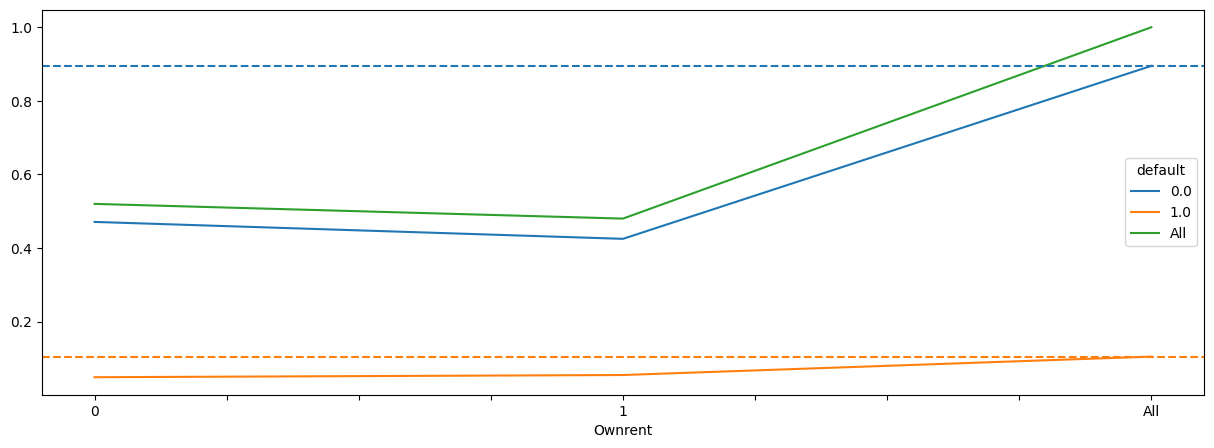

In [1178]:
pd.crosstab(aceptados["Ownrent"], y_aceptados, margins=True, normalize=True).round(3).plot(figsize=(15,5))
plt.axhline(y=yT_0, color='#1f77b4', linestyle='--')
plt.axhline(y=yT_1, color='#ff7f0e', linestyle='--')
plt.show()

pvalue: 0.8917523862803937 de la variable Ownrent


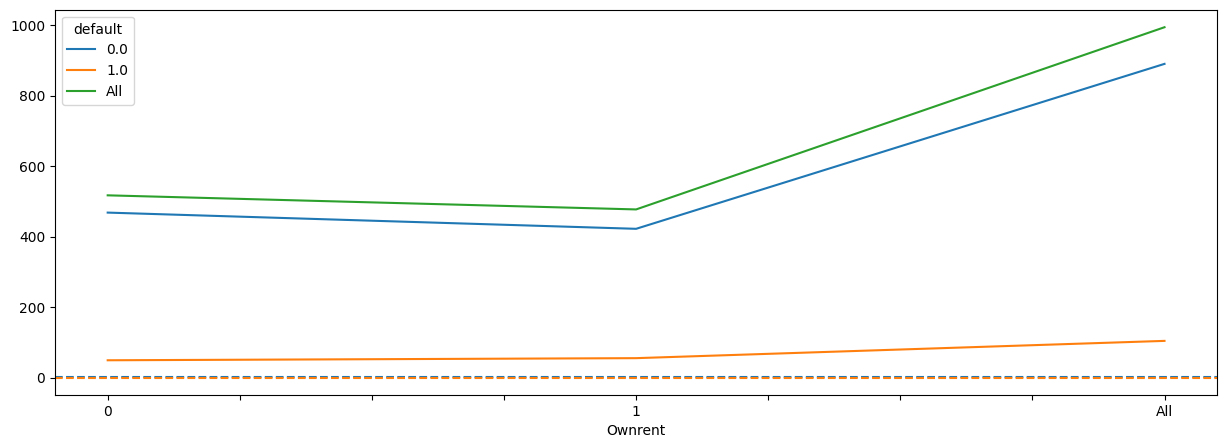

pvalue: 0.8651786641433323 de la variable Selfempl


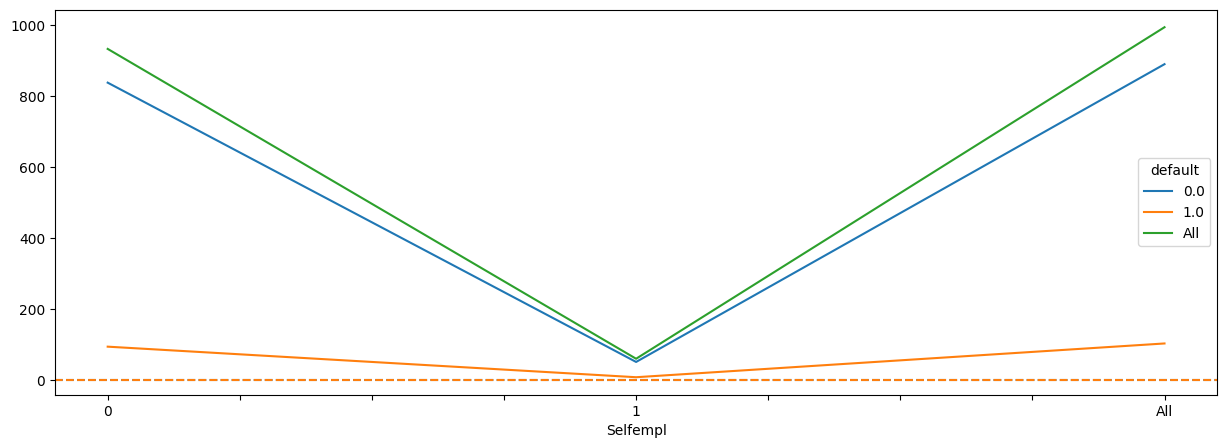

In [1243]:
def valoracion_variables_discretas(df, y, variable):
    ctabla = pd.crosstab(df[variable], y, margins=True).round(3)
    c, p, dof, expected = chi2_contingency(ctabla)
    print(f"pvalue: {p} de la variable {variable}")
    ctabla.plot(figsize=(15,5))
    plt.axhline(y=yT_0, color='#1f77b4', linestyle='--')
    plt.axhline(y=yT_1, color='#ff7f0e', linestyle='--')
    plt.show()

for variable in list_categorical:
    valoracion_variables_discretas(aceptados, y_aceptados, variable)

### Variables continuas

In [1180]:
def valoracion_variables_continuas(df, variable):    
    sns.displot(x=(df[variable]), kind="kde", fill=True)
    plt.show()
    sns.displot(x=np.log(df[variable]), kind="kde", fill=True)
    plt.show()

In [ ]:
def pvalue_continuas(aceptados, y_aceptados, variable):
    fvalue, pvalue = f_oneway(aceptados.loc[y_aceptados==0,[variable]], aceptados.loc[y_aceptados==1,[variable]])
    print(f"para la variable {variable}: ", fvalue, pvalue)
    valoracion_variables_continuas(aceptados)

for variable in list_continuas:
    pvalue_continuas(aceptados, y_aceptados, variable)

## Selección de variables
### Dividimos la muestra en entrenamiento y test

In [1182]:
dt_train, dt_test = train_test_split(aceptados,stratify=y_aceptados, test_size=.25, random_state=321)

In [1183]:
dt_train["default"].shape

(745,)

In [1184]:
dt_train["default"].mean()

0.10469798657718121

In [1185]:
dt_test["default"].shape

(249,)

In [1186]:
dt_test["default"].mean()

0.10441767068273092

## Proceso de tramificación, agrupación y trasformación WOE Completo

In [ ]:
# 1) Definimos la lista de nombres señalando cualse de ellas son las categóricas
Y = dt_train['default'].values
X = dt_train.drop(columns=['default']) #todas menos la primera que es el ID y la variable y
list_variables = X.columns.to_list()

list_categorical = ["Ownrent", "Selfempl"]
X

,Age,Income,Exp_Inc,Avgexp,Ownrent,Selfempl,Depndt,Inc_per,Cur_add,Major,Active
640,22.33333,1.8000,0.053426,80.05500,0,0,0,1.8000,48,0,1
1019,31.58333,3.0000,0.213618,533.62750,0,0,0,3.0000,7,1,1
71,24.25000,2.1300,0.021221,37.08333,0,0,1,1.0650,13,1,4
1267,49.83333,6.9000,0.060760,349.20170,1,0,3,1.7250,160,0,0
731,33.33333,2.1000,0.130838,228.96580,0,0,0,2.1000,6,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1177,56.91667,1.9200,0.200422,320.67580,1,1,1,0.9600,64,1,9
561,24.75000,2.2000,0.155049,284.25580,1,0,0,2.2000,36,1,6
1205,42.66667,2.5900,0.031484,67.53584,1,1,3,0.6475,96,1,5
1015,21.91667,2.4000,0.232639,465.19500,1,0,1,1.2000,168,1,4


In [1189]:
# 2) Definimos el criterio de selección
selection_criteria = {
    "iv": {"min": 0.02}  # no imponemos "max": 1}
}

In [1190]:
# En caso de que desee modificarse los valores por defecto en el proceso de tramificación de alguna variable puede hacerse en forma de diccionario

binning_fit_params={
    "purpose":{"cat_cutoff": 0.10}
}

In [1191]:
# 3) Definimos el proceso de Tramificación o BinningProcess
binning_process = BinningProcess(
    categorical_variables=list_categorical,
    variable_names=list_variables,
    selection_criteria=selection_criteria,
    binning_fit_params=binning_fit_params)

In [1192]:
# 4) Obtenemos los tramos optimos de todas las Variables
dt_train_binned = binning_process.fit(X, Y)

In [1193]:
dt_train_binned.summary().sort_values('iv')

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
6,Depndt,numerical,OPTIMAL,False,4,0.001195,0.000149,0.017626,0.0
4,Ownrent,categorical,OPTIMAL,False,2,0.011065,0.001382,0.052551,0.018997
5,Selfempl,categorical,OPTIMAL,True,2,0.031351,0.003863,0.047092,0.017764
9,Major,numerical,OPTIMAL,True,2,0.045261,0.0056,0.072848,0.062551
7,Inc_per,numerical,OPTIMAL,True,5,0.16223,0.018998,0.18212,0.198665
2,Exp_Inc,numerical,OPTIMAL,True,8,0.186633,0.021253,0.174951,0.00019
8,Cur_add,numerical,OPTIMAL,True,6,0.203367,0.024696,0.233806,0.005267
3,Avgexp,numerical,OPTIMAL,True,6,0.2415,0.028542,0.230116,0.088952
1,Income,numerical,OPTIMAL,True,3,0.261501,0.030713,0.199323,0.368584
0,Age,numerical,OPTIMAL,True,6,0.279293,0.033511,0.255526,0.009106


In [1194]:
dt_train_binned.information()

optbinning (Version 0.20.1)
Copyright (c) 2019-2024 Guillermo Navas-Palencia, Apache License 2.0

  Statistics
    Number of records                    745
    Number of variables                   11
    Target type                       binary

    Number of numerical                    9
    Number of categorical                  2
    Number of selected                     9

  Time                                2.3311 sec



In [1195]:
dt_train_binned.get_support()

array([ True,  True,  True,  True, False,  True, False,  True,  True,
        True,  True])

In [1196]:
# Podemos transformar las variables WOE
dt_train_woe=dt_train_binned.transform(X, metric="woe")

In [1197]:
dt_train_woe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 745 entries, 640 to 747
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age       745 non-null    float64
 1   Income    745 non-null    float64
 2   Exp_Inc   745 non-null    float64
 3   Avgexp    745 non-null    float64
 4   Selfempl  745 non-null    float64
 5   Inc_per   745 non-null    float64
 6   Cur_add   745 non-null    float64
 7   Major     745 non-null    float64
 8   Active    745 non-null    float64
dtypes: float64(9)
memory usage: 58.2 KB


In [1198]:
dt_train_woe

,Age,Income,Exp_Inc,Avgexp,Selfempl,Inc_per,Cur_add,Major,Active
640,0.352619,0.054903,0.069492,0.140588,0.051143,1.682560,-0.315855,0.536651,2.459089
1019,-0.294898,0.054903,-0.368308,-0.521376,0.051143,-0.090356,0.330015,-0.084658,2.459089
71,1.437438,0.054903,1.861252,0.140588,0.051143,0.265358,0.330015,-0.084658,0.257480
1267,-0.554992,-0.936243,0.069492,-0.052846,0.051143,1.682560,-0.229159,0.536651,2.459089
731,-0.294898,0.054903,-0.178431,0.449173,0.051143,-0.090356,0.330015,0.536651,2.459089
...,...,...,...,...,...,...,...,...,...
1177,-0.554992,0.054903,-0.368308,-0.052846,-0.614605,0.265358,-0.315855,-0.084658,-0.300255
561,1.437438,0.054903,-0.337792,1.682560,0.051143,-0.090356,-0.718965,-0.084658,0.257480
1205,-0.294898,0.054903,0.069492,0.140588,-0.614605,-0.121699,-0.229159,-0.084658,0.257480
1015,0.352619,0.054903,-0.368308,-0.521376,0.051143,0.265358,-0.229159,-0.084658,0.257480


In [1199]:
# Ahora aplicaríamos la misma transformación pero al conjunto de test (si hubiera que puntuar a nuevos clientes haríamos lo mismo)

Y_test = dt_test['default'].values
X_test = dt_test.drop(columns=['default']) #todas menos la primera que es el ID y la variable y

dt_test_woe=dt_train_binned.transform(X_test, metric="woe")
dt_test_woe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 249 entries, 191 to 1112
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age       249 non-null    float64
 1   Income    249 non-null    float64
 2   Exp_Inc   249 non-null    float64
 3   Avgexp    249 non-null    float64
 4   Selfempl  249 non-null    float64
 5   Inc_per   249 non-null    float64
 6   Cur_add   249 non-null    float64
 7   Major     249 non-null    float64
 8   Active    249 non-null    float64
dtypes: float64(9)
memory usage: 19.5 KB


In [1200]:
dt_test_woe

,Age,Income,Exp_Inc,Avgexp,Selfempl,Inc_per,Cur_add,Major,Active
191,0.310655,0.054903,0.069492,0.140588,0.051143,-0.482576,0.285337,-0.084658,0.257480
147,0.310655,0.054903,0.069492,0.140588,0.051143,-0.090356,1.221215,0.536651,2.459089
649,0.703799,-0.936243,-0.006015,-0.052846,0.051143,-0.482576,0.330015,-0.084658,-0.300255
145,-0.294898,1.504577,-0.337792,-0.521376,0.051143,-0.482576,1.221215,-0.084658,-1.204038
1038,-0.554992,-0.936243,-0.006015,-0.521376,0.051143,-0.482576,-0.718965,-0.084658,2.459089
...,...,...,...,...,...,...,...,...,...
847,-0.294898,0.054903,-0.006015,0.140588,0.051143,-0.121699,-0.718965,-0.084658,-0.300255
152,0.703799,0.054903,0.069492,0.140588,0.051143,-0.090356,-0.315855,-0.084658,0.257480
22,-0.294898,1.504577,-0.006015,-0.052846,0.051143,0.265358,-0.315855,-0.084658,0.257480
1118,1.437438,0.054903,-0.178431,0.140588,0.051143,1.682560,1.221215,0.536651,-0.300255


## Estimacion del modelo

In [1201]:

# Directamente con el método Scorecard
estimator = LogisticRegression(solver="lbfgs", penalty="l2")
# estimator = LogisticRegression(solver="liblinear", penalty="l1")
# Establecemos los parámetros para la transformación de probabilidades en puntos de calidad crediticia o score

pdo_0 =40
scorecard_points_0= 600 
odds_0_B= 50 # (equivalente a  odds_0 =1/50 )

tarjeta= Scorecard(binning_process=binning_process,
                   estimator=estimator,
                   scaling_method="pdo_odds",
                   scaling_method_params={"pdo":pdo_0, "odds": odds_0_B, "scorecard_points": scorecard_points_0})

tarjeta.fit(X, Y, show_digits=4)

Scorecard(binning_process=BinningProcess(binning_fit_params={'purpose': {'cat_cutoff': 0.1}},
                                         categorical_variables=['Ownrent',
                                                                'Selfempl'],
                                         selection_criteria={'iv': {'min': 0.02}},
                                         variable_names=['Age', 'Income',
                                                         'Exp_Inc', 'Avgexp',
                                                         'Ownrent', 'Selfempl',
                                                         'Depndt', 'Inc_per',
                                                         'Cur_add', 'Major',
                                                         'Active']),
          estimator=LogisticRegression(), scaling_method='pdo_odds',
          scaling_method_params={'odds': 50, 'pdo': 40,
                                 'scorecard_points': 600})

In [1202]:
tarjeta.information(print_level=2)

optbinning (Version 0.20.1)
Copyright (c) 2019-2024 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    binning_process                      yes   * U
    estimator                            yes   * U
    scaling_method                  pdo_odds   * U
    scaling_method_params                yes   * U
    intercept_based                    False   * d
    reverse_scorecard                  False   * d
    rounding                           False   * d
    verbose                            False   * d
  End options

  Statistics
    Number of records                    745
    Number of variables                   11
    Target type                       binary

    Number of numerical                    9
    Number of categorical                  2
    Number of selected                     9

  Timing
    Total time                          2.56 sec
    Binning process                     2.52 sec   ( 98.25%)
    Estimator                           0.00 sec   (  0.18%

In [1203]:
# Podemos obtener los parámetros del modelo de regresión logística

tarjeta.table(style="detailed")[["Variable","Coefficient"]].groupby(["Variable", "Coefficient"]).nunique()

,
Variable,Coefficient
Active,-0.881119
Age,-0.544450
Avgexp,-0.576706
Cur_add,-0.574289
Exp_Inc,-0.982779
Inc_per,-0.634951
Income,-0.574788
Major,-0.416964
Selfempl,-0.406389


In [1204]:
tarjeta.table().head(60)

,Variable,Bin,Points
0,Age,"(-inf, 21.2083)",64.756664
1,Age,"[21.2083, 23.7083)",66.075139
2,Age,"[23.7083, 25.2917)",100.159097
3,Age,"[25.2917, 29.1250)",77.108886
4,Age,"[29.1250, 48.2917)",45.730781
5,Age,"[48.2917, inf)",37.558876
6,Age,Special,54.996200
7,Age,Missing,54.996200
0,Income,"(-inf, 4.3100)",56.817311
1,Income,"[4.3100, 5.7850)",104.902647


In [1205]:
tarjeta.table(style="detailed").head(16)

,Variable,Bin id,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Coefficient,Points
0,Age,0,"(-inf, 21.2083)",38,0.051007,35,3,0.078947,0.310655,0.004353,0.000542,-0.544450,64.756664
1,Age,1,"[21.2083, 23.7083)",79,0.106040,73,6,0.075949,0.352619,0.011468,0.001426,-0.544450,66.075139
2,Age,2,"[23.7083, 25.2917)",74,0.099329,72,2,0.027027,1.437438,0.118308,0.013634,-0.544450,100.159097
3,Age,3,"[25.2917, 29.1250)",128,0.171812,121,7,0.054688,0.703799,0.064514,0.007902,-0.544450,77.108886
4,Age,4,"[29.1250, 48.2917)",361,0.484564,312,49,0.135734,-0.294898,0.047313,0.005893,-0.544450,45.730781
5,Age,5,"[48.2917, inf)",65,0.087248,54,11,0.169231,-0.554992,0.033336,0.004114,-0.544450,37.558876
6,Age,6,Special,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,-0.544450,54.996200
7,Age,7,Missing,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,-0.544450,54.996200
0,Income,0,"(-inf, 4.3100)",592,0.794631,533,59,0.099662,0.054903,0.002344,0.000293,-0.574788,56.817311
1,Income,1,"[4.3100, 5.7850)",79,0.106040,77,2,0.025316,1.504577,0.135113,0.015457,-0.574788,104.902647


### Diagnosis del modelo

In [1206]:
# obtenemos las predicciones
Y_pred=tarjeta.predict_proba(X)[:,1]

# Calculamos la media
Y_pred.mean().round(5)

0.10468

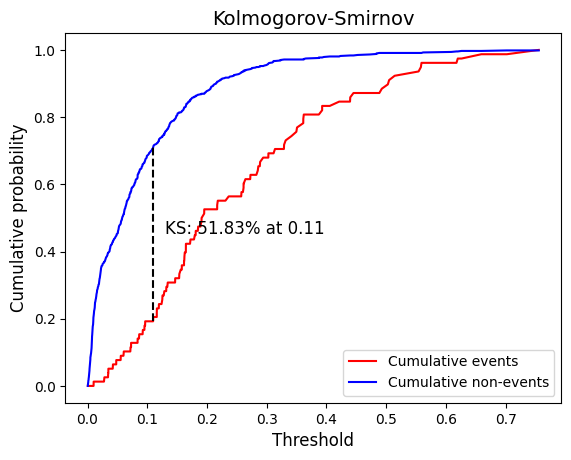

In [1207]:
# Para elegir el punto de corte puede utilizarse el Plot Kolmogorov-Smirnov (KS)
plot_ks(Y, Y_pred)

El punto de corte que maximiza el f1_score es:  0.26
y el máximo se alcanza en  0.429


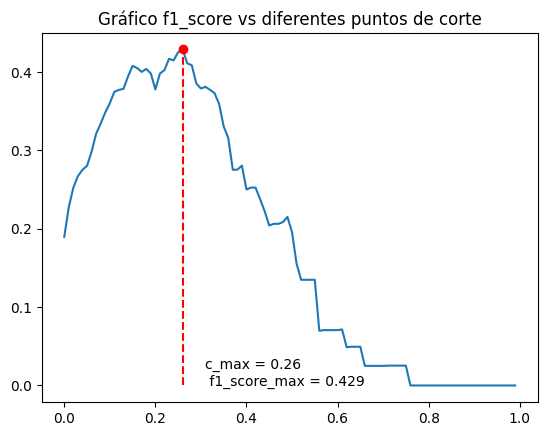

In [1208]:
# También puede utilizarse el máximo del f1_score
# definimos un vector de puntos de corte
c=np.arange(0,1,0.01)
# calculamos el f1_score para cada punto de corte
f1_score_ = [f1_score(dt_train["default"],np.multiply(Y_pred>c_,1)) for c_ in c]
# obtenemos el punto de corte que maximiza el f1_score
c_max = c[np.argmax(f1_score_)]
print("El punto de corte que maximiza el f1_score es: ", c_max)
print("y el máximo se alcanza en ", np.max(f1_score_).round(3))

# hacemos un gráfico de c y los f1_score correspondientes
plt.plot(c,f1_score_)
plt.stem(c_max, np.max(f1_score_),linefmt='r--', markerfmt='ro', basefmt='r--')
plt.title("Gráfico f1_score vs diferentes puntos de corte")
plt.text(c_max+0.05, 0, "c_max = "+str(c_max.round(2))+"\n f1_score_max = "+str(np.max(f1_score_).round(3)))
plt.show()

c_maxF1=c_max

El punto de corte que maximiza el índice de Youden es:  0.11
y el máximo se alcanza en  0.509


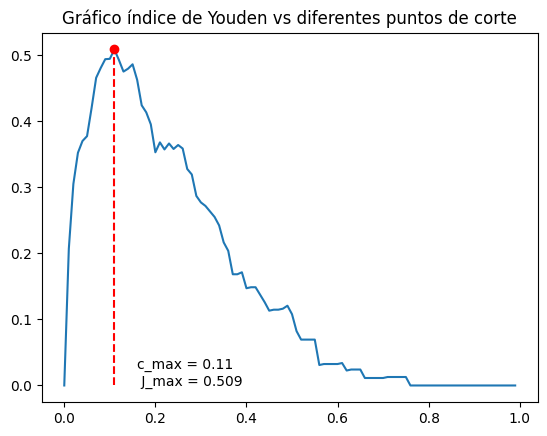

In [1209]:
# método de Youden (J) para obtener el punto de corte óptimo
# definimos un vector de puntos de corte (c) y de probabilidad de aceptación (p)
c=np.arange(0,1,0.01)

# Calculamos el estadístico J de Youden para cada punto de corte= Sensibilidad + Especificidad -1
J= [balanced_accuracy_score(dt_train["default"],np.multiply(Y_pred>c_,1), adjusted=True) for c_ in c ]
# obtenemos el punto de corte que maximiza el índice de Youden
c_max = c[np.argmax(J)]
print("El punto de corte que maximiza el índice de Youden es: ", c_max)
print("y el máximo se alcanza en ", np.max(J).round(3))

# gráfico de c y los índices de Youden correspondientes
plt.plot(c,J)
plt.stem(c_max, np.max(J),linefmt='r--', markerfmt='ro', basefmt='r--')
plt.title("Gráfico índice de Youden vs diferentes puntos de corte")
plt.text(c_max+0.05, 0, "c_max = "+str(c_max.round(2))+"\n J_max = "+str(np.max(J).round(3)))
plt.show()

In [1210]:
# Se podría utilizar simplemente la frecuencia observada, o utilizar el punto donde se alcanza el maximo del F1 Score
Prob_Corte=Y.mean()
#Prob_Corte=c_maxF1
print(' Punto de Corte seleccionado:', Prob_Corte.round(2),'\n',
      'Frecuencia media de eventos (y=1):', Y.mean().round(2), '\n',
      'máximo del F1-score :', c_maxF1)

 Punto de Corte seleccionado: 0.1 
 Frecuencia media de eventos (y=1): 0.1 
 máximo del F1-score : 0.26


In [1211]:
dt_train["Y_pronostico"]=np.multiply(Y_pred>Prob_Corte,1)

In [1212]:
# Para comprobar la bondad de nuestras predicciones voy a comparar resultados con la tabla de confusión

# Primero estimo la precisión (los aciertos sobre el total de mis pronósticos)
pd.crosstab(dt_train["default"],dt_train["Y_pronostico"],margins=True, normalize=1).round(3)

Y_pronostico,0,1,All
default,,,
0.0,0.969,0.763,0.895
1.0,0.031,0.237,0.105


Veamos cuantos falsos negativos tenemos

In [1213]:
# Ahora estimo la exhaustividad o recall (Aciertos sobre los casos reales):
# la sensibilidad (sobre los positivos y=1), y la Especificidad (sobre los negativos y=0)

pd.crosstab(dt_train["default"],dt_train["Y_pronostico"],margins=True, normalize=0).round(3)

Y_pronostico,0,1
default,,
0.0,0.696,0.304
1.0,0.192,0.808
All,0.643,0.357


In [1214]:
# Por último un resumen global de aciertos
f1_score(dt_train["default"],dt_train["Y_pronostico"])

0.36627906976744184

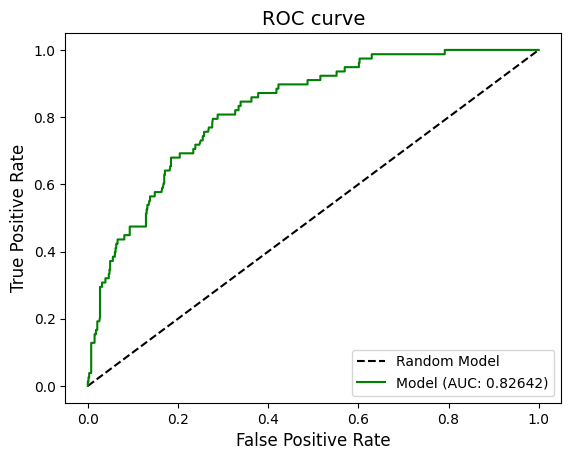

In [1215]:
# Diagnosis Curva ROC
plot_auc_roc(Y,Y_pred)

In [1216]:
#### OJO que la diagnosis debe hacerse fuera de la muestra de entrenamiento
# obtenmos las predicciones
Y_test_pred=tarjeta.predict_proba(X_test)[:,1]

# Calculamos la media
Y_test_pred.mean().round(5)

0.10058

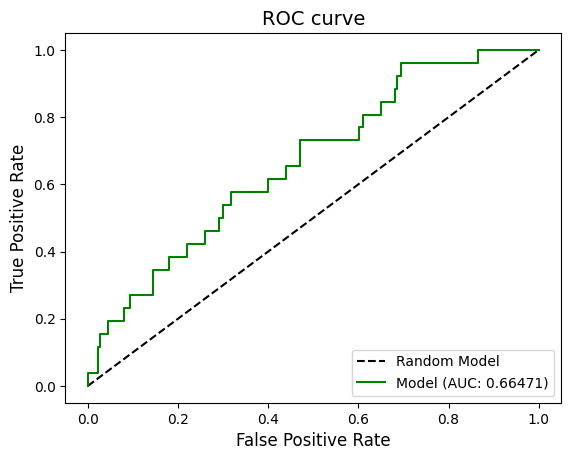

In [1217]:
# Diagnosis Curva ROC
plot_auc_roc(Y_test,Y_test_pred)

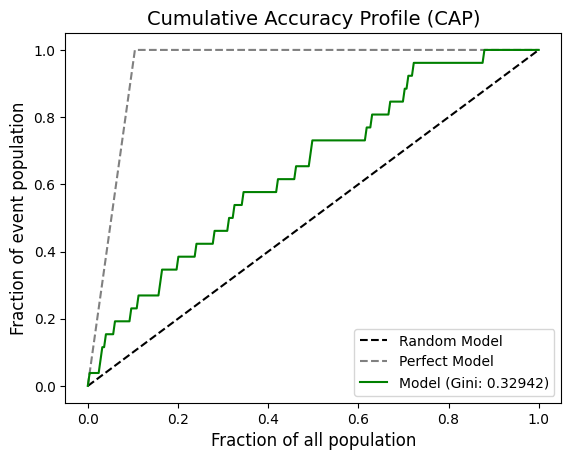

In [1218]:
plot_cap(Y_test,Y_test_pred)

In [1219]:
dt_test["Y_pronostico"]=np.multiply(Y_test_pred>Prob_Corte,1)

# Primero estimo la precisión (los aciertos sobre el total de mis pronósticos)
print("\n Precisión:\n", pd.crosstab(dt_test["default"],dt_test["Y_pronostico"],margins=True, normalize=1).round(3))

# Ahora estimo la exhaustividad o recall (Aciertos sobre los casos reales):
# la sensibilidad (sobre los positivos y=1), y la Especificidad (sobre los negativos y=0)
print("\n exhaustividad:\n",pd.crosstab(dt_test["default"],dt_test["Y_pronostico"],margins=True, normalize=0).round(3))

# Por último un resumen global de aciertos
print("\n f1-score:",f1_score(dt_test["default"],dt_test["Y_pronostico"]))


 Precisión:
 Y_pronostico      0      1    All
default                          
0.0           0.929  0.827  0.896
1.0           0.071  0.173  0.104

 exhaustividad:
 Y_pronostico      0      1
default                   
0.0           0.700  0.300
1.0           0.462  0.538
All           0.675  0.325

 f1-score: 0.2616822429906542


In [1220]:
# Ahora vamos a calcular los score o puntuaciones.
#Que podemos hacer  con la función score
score = tarjeta.score(X)

print("Puntuación mínima: ", score.min().round(2))
print("Puntuación máxima: ",score.max().round(2))
print("Puntuación media : ",score.mean().round(2))  


# Transformación lineal según apuntes
# Factor= (pdo_0/log(2))
# Offset = scorecard_points_0+(pdo_0/log(2))*log(odds0_0)
# score= Offset - Factor *log(odds)

Factor= (pdo_0/np.log(2))
Offset = scorecard_points_0+Factor*np.log(1/odds_0_B)

#Podríamos haber calculado la puntuación también manualmente
score2= Offset-Factor*np.log(Y_pred/(1-Y_pred))

# Podemos comprobar que los resultados son los mismos   
print('Podemos comprobar que los resultados son los mismos con el cálculo manual')   
print("Puntuación mínima: ",score2.min().round(2))
print("Puntuación máxima: ",score2.max().round(2))
print("Puntuación media : ",score2.mean().round(2))

datos_score=pd.DataFrame(np.transpose([score,score2, Y,Y_pred]), columns=['score','scoreManual','Y','Y_pred'])

# datos_score.to_excel("score_p1.xlsx")


Puntuación mínima:  309.18
Puntuación máxima:  820.24
Puntuación media :  542.5
Podemos comprobar que los resultados son los mismos con el cálculo manual
Puntuación mínima:  309.18
Puntuación máxima:  820.24
Puntuación media :  542.5


In [1221]:

Score_Corte= Offset-Factor*np.log(Prob_Corte/(1-Prob_Corte))

print("La probabilida de corte de:", Prob_Corte, "equivale a una puntuación de corte de:", Score_Corte.round(2) )


La probabilida de corte de: 0.10469798657718121 equivale a una puntuación de corte de: 498.09


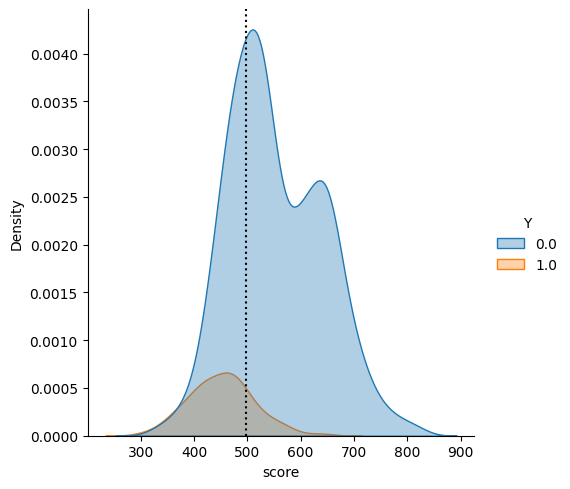

In [1222]:
# Ahora representamos en un gráfico cómo separa el modelo a los buenos y los malos
datos_score=pd.DataFrame(np.transpose([score,Y]), columns=['score','Y'])
sns.displot(data=datos_score, x='score', label="event", hue='Y', alpha=0.35,kind="kde", fill=True, common_norm=True)
plt.axvline(Score_Corte, color='k', linestyle=":")

# Segunda etapa: Construccion del modelo con los aceptados y los rechazados

## Realizamos la inferencia de los rechazados 

In [1223]:
X_rechazados = Rechazados.drop(columns=['default']) #todas menos la variable y (que de hecho estaba vacía por que hay que estimarla)
Y_rechazados_pred=tarjeta.predict_proba(X_rechazados)[:,1]
Rechazados["default"]=np.multiply(Y_rechazados_pred>Prob_Corte,1)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_20388\799553675.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Rechazados["default"]=np.multiply(Y_rechazados_pred>Prob_Corte,1)


In [1224]:
print(Rechazados["default"].value_counts(normalize=True))

default
0    0.680412
1    0.319588
Name: proportion, dtype: float64


In [1225]:
# Hago también una primera estimazión de la puntuación de los nuevos clientes para ver si hay diferencias con y sin rechazados
X_Nuevos = Nuevos.drop(columns=['default']) #todas menos la variable y (que de hecho estaba vacía por que hay que estimarla)
Y_Nuevos_pred=tarjeta.predict_proba(X_Nuevos)[:,1]
Nuevos["Prob_Sinrechazados"]=np.multiply(Y_Nuevos_pred,1)
Nuevos["y_Sinrechazados"]=np.multiply(Y_Nuevos_pred>Prob_Corte,1)

## Anexamos los datos de los Rechazados inferidos a los aceptados

In [1226]:
dt=pd.concat([aceptados,Rechazados], axis=0)
dt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1285 entries, 0 to 1281
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   default   1285 non-null   float64
 1   Age       1285 non-null   float64
 2   Income    1285 non-null   float64
 3   Exp_Inc   1285 non-null   float64
 4   Avgexp    1285 non-null   float64
 5   Ownrent   1285 non-null   int64  
 6   Selfempl  1285 non-null   int64  
 7   Depndt    1285 non-null   int64  
 8   Inc_per   1285 non-null   float64
 9   Cur_add   1285 non-null   int64  
 10  Major     1285 non-null   int64  
 11  Active    1285 non-null   int64  
dtypes: float64(6), int64(6)
memory usage: 130.5 KB


In [1227]:
dt['default'].value_counts()

default
0.0    1088
1.0     197
Name: count, dtype: int64

In [1228]:
dt['default'].value_counts(normalize=True)

default
0.0    0.846693
1.0    0.153307
Name: proportion, dtype: float64

## Reestimo el modelo con todos, Aceptados y rechazados.

In [1229]:
### Dividimos la muestra en entrenamiento y test
dt_train, dt_test = train_test_split(dt,stratify=dt["default"], test_size=.25, random_state=1234)
print(dt_train["default"].mean(),dt_test["default"].mean())
### Defino la tramificación óptima

# 1) Definimos la lista de nombres señalando cuales de ellas son las categóricas
Y = dt_train['default'].values
X = dt_train.drop(columns=['default']) #todas menos la variable y
list_variables = X.columns.values.tolist()
list_categorical = ["Ownrent", "Selfempl"]

# 2) Definimos el criterio de selección
selection_criteria = {
    "iv": {"min": 0.02} #, "max": 1}
}
# En caso de que desee modificarse los valores por defecto en el proceso de tramificación de alguna variable puede hacerse en forma de diccionario

binning_fit_params={
    "purpose":{"cat_cutoff": 0.10}
}

# 3) Definimos el proceso de Tramificación o BinningProcess
binning_process = BinningProcess(
    categorical_variables=list_categorical,
    variable_names=list_variables,
    selection_criteria=selection_criteria,
    binning_fit_params=binning_fit_params)

# 4) Obtenemos los tramos optimos de todas las Variables
dt_train_binned = binning_process.fit(X, Y)
dt_train_binned.summary().sort_values('iv')

0.1536863966770509 0.15217391304347827


,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
6,Depndt,numerical,OPTIMAL,False,4,0.000577,0.000072,0.009642,0.0
5,Selfempl,categorical,OPTIMAL,False,2,0.005921,0.000738,0.019731,0.002503
9,Major,numerical,OPTIMAL,False,2,0.009066,0.001131,0.0354,0.010326
4,Ownrent,categorical,OPTIMAL,False,2,0.016754,0.002093,0.064401,0.038984
7,Inc_per,numerical,OPTIMAL,True,7,0.120417,0.014195,0.152943,0.009309
1,Income,numerical,OPTIMAL,True,4,0.25804,0.029055,0.18899,0.324369
8,Cur_add,numerical,OPTIMAL,True,7,0.291611,0.035382,0.275941,0.002678
0,Age,numerical,OPTIMAL,True,9,0.454373,0.051205,0.32066,0.000535
3,Avgexp,numerical,OPTIMAL,True,6,0.544153,0.064669,0.385293,0.129133
2,Exp_Inc,numerical,OPTIMAL,True,6,0.712594,0.082184,0.421199,0.122939


In [1230]:
# Directamente con el método Scorecard
estimator = LogisticRegression(solver="lbfgs",penalty=None)
# estimator = LogisticRegression(solver="liblinear",penalty="l1")

# Establecemos los parámetros para la transformación de probabilidades en puntos de calidad crediticia o score

pdo_0 =40
scorecard_points_0= 600 
odds_0_B= 50 # (equivalente a  odds_0 =1/50 )

tarjeta= Scorecard(binning_process=binning_process,
                   estimator=estimator,
                   scaling_method="pdo_odds",
                   scaling_method_params={"pdo":pdo_0, "odds": odds_0_B, "scorecard_points": scorecard_points_0})

tarjeta.fit(X, Y, show_digits=4)

Scorecard(binning_process=BinningProcess(binning_fit_params={'purpose': {'cat_cutoff': 0.1}},
                                         categorical_variables=['Ownrent',
                                                                'Selfempl'],
                                         selection_criteria={'iv': {'min': 0.02}},
                                         variable_names=['Age', 'Income',
                                                         'Exp_Inc', 'Avgexp',
                                                         'Ownrent', 'Selfempl',
                                                         'Depndt', 'Inc_per',
                                                         'Cur_add', 'Major',
                                                         'Active']),
          estimator=LogisticRegression(penalty=None), scaling_method='pdo_odds',
          scaling_method_params={'odds': 50, 'pdo': 40,
                                 'scorecard_points': 600})

In [1231]:
# obtenmos las predicciones
Y_pred=tarjeta.predict_proba(X)[:,1]

# Calculamos la media
Y_pred.mean().round(5)

0.15371

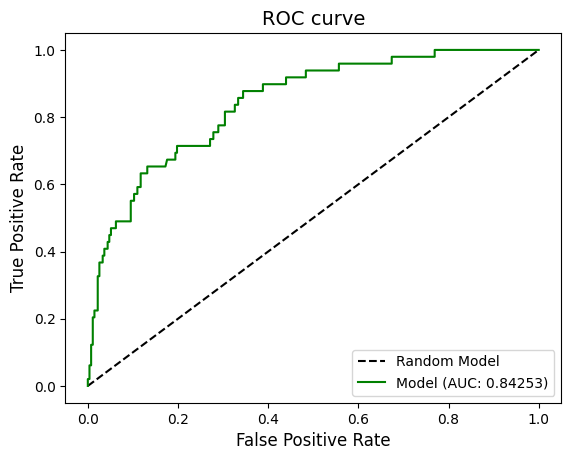

In [1232]:
#### OJO que la diagnosis debe hacerse fuera de la muestra de entrenamiento
# obtenmos las predicciones
Y_test = dt_test['default'].values
X_test = dt_test.drop(columns=['default']) #todas menos la primera que es el ID y la variable y

Y_test_pred=tarjeta.predict_proba(X_test)[:,1]

# Diagnosis Curva ROC
plot_auc_roc(Y_test,Y_test_pred)

# **TERCERA ETAPA: Puntuación de las nuevas solicitudes**

El punto de corte que maximiza el f1_score es:  0.32
y el máximo se alcanza en  0.583


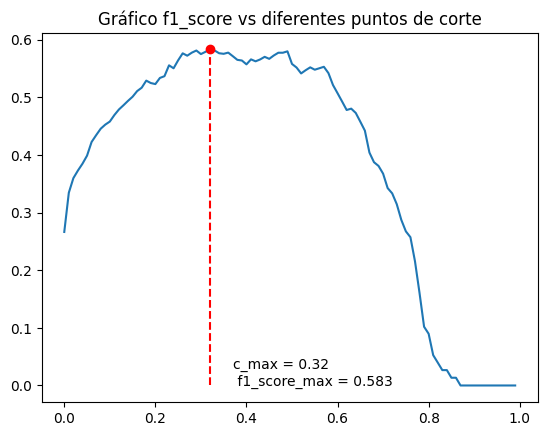

 Punto de Corte seleccionado: 0.1536863966770509 
 Frecuencia media de eventos (y=1): 0.15 
 máximo del F1-score se alcanza para prob: 0.32 
 y el máximo F1-secore es de 0.505


In [1233]:
# primero estimo el punto de corte utilizando o bien el valor medio o bien el máximo del f1-score pero
# del segundo modelo (modelo completo con Aceptados y Aceptados)

# Punto de corte el máximo del f1_score
# definimos un vector de puntos de corte
c=np.arange(0,1,0.01)
# calculamos el f1_score para cada punto de corte
f1_score_ = [f1_score(dt_train["default"],np.multiply(Y_pred>c_,1)) for c_ in c]
# obtenemos el punto de corte que maximiza el f1_score
c_max = c[np.argmax(f1_score_)]
print("El punto de corte que maximiza el f1_score es: ", c_max)
print("y el máximo se alcanza en ", np.max(f1_score_).round(3))

# hacemos un gráfico de c y los f1_score correspondientes
plt.plot(c,f1_score_)
plt.stem(c_max, np.max(f1_score_),linefmt='r--', markerfmt='ro', basefmt='r--')
plt.title("Gráfico f1_score vs diferentes puntos de corte")
plt.text(c_max+0.05, 0, "c_max = "+str(c_max.round(2))+"\n f1_score_max = "+str(np.max(f1_score_).round(3)))
plt.show()

c_maxF1=c_max


# Determino el punto de corte óptimo
# Se podría utilizar simplemente la frecuencia observada, pdro voy a utilizar el punto donde se alcanza el maximo del F1 Score
Prob_Corte=Y.mean()
# Prob_Corte=c_maxF1
print(' Punto de Corte seleccionado:', Prob_Corte,'\n',
      'Frecuencia media de eventos (y=1):', round(Y.mean(),2), '\n',
      'máximo del F1-score se alcanza para prob:', c_maxF1, '\n',
      'y el máximo F1-secore es de', f1_score(Y,Y_pred>Prob_Corte).round(3))



In [1234]:
# Ahora ya podemos puntuar a los nuevos clientes con el modelo completo

X_Nuevos = Nuevos.drop(columns=['default','Prob_Sinrechazados','y_Sinrechazados']) #todas menos la variable y (que de hecho estaba vacía por que hay que estimarla)
Y_Nuevos_pred=tarjeta.predict_proba(X_Nuevos)[:,1]
Nuevos["Prob_Conrechazados"]=np.multiply(Y_Nuevos_pred,1)
Nuevos["y_Conrechazados"]=np.multiply(Y_Nuevos_pred>Prob_Corte,1)


In [1235]:
Nuevos[["ID", "y_Conrechazados"]]

,ID,y_Conrechazados
1285,1286,0
1286,1287,0
1287,1288,0
1288,1289,0
1289,1290,0
1290,1291,0
1291,1292,0
1292,1293,1
1293,1294,0
1294,1295,0


In [1236]:
print("\n Prob estimada de Impago de los Nuevos Solicitantes SIN incluir Rechazados (primer modelo):",Nuevos["Prob_Sinrechazados"].mean().round(3))
print("\n Prob estimada de Impago de los Nuevos Solicitantes CON inferencia de Rechazados (segundo modelo):",Nuevos["Prob_Conrechazados"].mean().round(3))  



 Prob estimada de Impago de los Nuevos Solicitantes SIN incluir Rechazados (primer modelo): 0.095

 Prob estimada de Impago de los Nuevos Solicitantes CON inferencia de Rechazados (segundo modelo): 0.131


## Seguimiento del modelo: PSI (Population Stability Index)


In [1237]:
# Supongamos que tenemos un conjunto de nuevos datos que hemos ido recopilando después de la puesta en producción del modelo,
# y queremos utilizar esos nuevos datos para saber si es necesario revisar el modelo o si por el contrario podemos seguir utilizándolo

# Como en la base de datos no disponemos de este tipo de datos voy a suponer simplemente que los datos de test son los nuevos datos,

dt_nuevosdatos= dt_test.copy() 





# Valores nuevos
Y_nuevo = dt_nuevosdatos['default'].values
X_nuevo = dt_nuevosdatos.drop(columns=['default']) #todas menos la primera que es el ID y la variable y

# Valores de entrenamiento
Y = dt_train['default'].values
X = dt_train.drop(columns=['default']) #todas menos la variable y


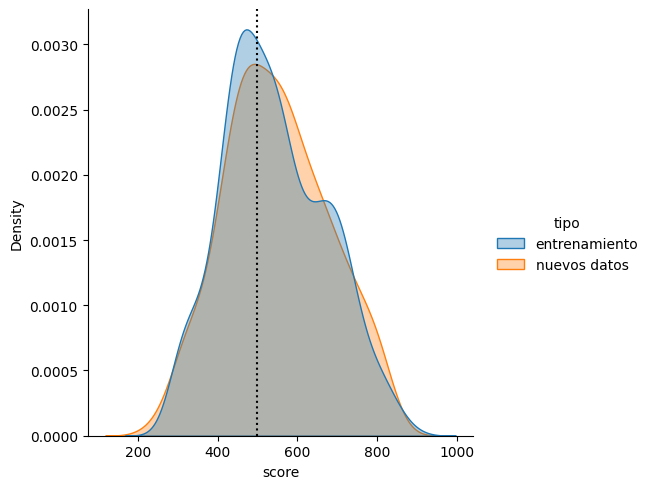

In [1238]:

# ¿se distibuyen igual las probabilidades esperadas?
score_train = tarjeta.score(X)
score_nuevo = tarjeta.score(X_nuevo)

datos_score_psi1=pd.DataFrame(np.transpose([score_train,Y]), columns=['score','Y'])
datos_score_psi1['tipo']='entrenamiento'

datos_score_psi2=pd.DataFrame(np.transpose([score_nuevo,Y_nuevo]), columns=['score','Y'])
datos_score_psi2['tipo']='nuevos datos'

datos_score_psi= pd.concat([datos_score_psi1,datos_score_psi2])
sns.displot(data=datos_score_psi, x='score', label="event", hue='tipo', alpha=0.35,kind="kde", fill=True,common_norm=False)
plt.axvline(Score_Corte, color='k', linestyle=":")


In [1239]:

# Estimo el psi
# Defino la tarjeta a evalear
# psi=ScorecardMonitoring(tarjeta, psi_method="cart",psi_min_bin_size=0.10, psi_n_bins=5)
psi=ScorecardMonitoring(tarjeta, psi_method= "quantile", psi_n_bins=3)



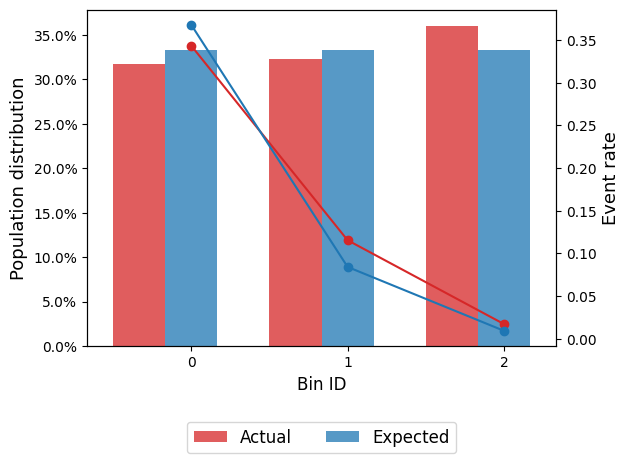

                     Bin  Count A  Count E  Count A (%)  Count E (%)       PSI
0         (-inf, 473.40)      102      321     0.316770     0.333333  0.000844
1       [473.40, 590.37)      104      321     0.322981     0.333333  0.000327
2          [590.37, inf)      116      321     0.360248     0.333333  0.002090
Totals                        322      963     1.000000     1.000000  0.003261
                Bin  Count A  Count E  Event rate A  Event rate E  statistic   p-value
0    (-inf, 473.40)      102      321      0.343137      0.367601   0.200653  0.654195
1  [473.40, 590.37)      104      321      0.115385      0.084112   0.921721  0.337023
2     [590.37, inf)      116      321      0.017241      0.009346   0.469634  0.493156


In [1240]:
psi.fit(X_actual=X_nuevo, y_actual=Y_nuevo, X_expected=X, y_expected=Y)

psi.psi_plot()
print(psi.psi_table().to_string())
print(psi.tests_table().to_string())


In [1241]:
psi.system_stability_report()

-----------------------------------
Monitoring: System Stability Report
-----------------------------------

  Population Stability Index (PSI)


    PSI total:      0.0033 (No significant change)

         PSI bin  Count  Count (%)
    [0.00, 0.10)      3        1.0
    [0.10, 0.25)      0        0.0
    [0.25, Inf+)      0        0.0

  Significance tests (H0: actual == expected)

     p-value bin  Count  Count (%)
    [0.00, 0.05)      0   0.000000
    [0.05, 0.10)      0   0.000000
    [0.10, 0.50)      2   0.666667
    [0.50, 1.00)      1   0.333333

  Target analysis

               Metric  Actual Actual (%)  Expected Expected (%)
    Number of records     322          -       963            -
        Event records      49   0.152174       148     0.153686
    Non-event records     273   0.847826       815     0.846314

  Performance metrics

                 Metric   Actual  Expected  Diff A - E
     True positive rate 0.367347  0.439189   -0.071842
     True negative rate 0.967

In [1242]:
psi.psi_variable_table(style="summary").sort_values('PSI')

,Variable,PSI
6,Income,0.002439
3,Cur_add,0.008953
4,Exp_Inc,0.014601
1,Age,0.020822
5,Inc_per,0.021948
0,Active,0.027734
2,Avgexp,0.038639


In [ ]:
#list_continuas = ["Age", "Income", "Exp_Inc", "Avgexp", "Depndt", "Inc_per", "Cur_add", "Major", "Active"]
list_continuas = ["Age", "Income", "Avgexp", "Inc_per", "Cur_add", "Active"]
list_categorical = ["Ownrent", "Selfempl", "extr_age", "extr_avg"]


for i in [aceptados, Nuevos, Rechazados]:
    print(i)
    i = i[list_continuas+list_categorical]